# Multi agent collaboration patterns
Shows the skeleton code for collaboration patterns.

### Business use case

A retailer deals with multiple product categories. Retailer is looking to build a customer service system that would streamline the customer service. 

### Comparison


| Feature               | **Swarm Pattern**                     | **Blackboard Pattern**               | **Hierarchical Pattern**             | **Supervisor Pattern**               |
|-----------------------|--------------------------------------|--------------------------------------|--------------------------------------|--------------------------------------|
| **Control Flow**      | Decentralized, parallel              | Controller-driven, sequential        | Tree-structured, top-down            | Centralized supervisor, dynamic      |
| **Decision Making**   | Voting/consensus among agents        | Shared blackboard state              | Parent agents synthesize child outputs | Supervisor evaluates & combines      |
| **Agent Awareness**   | Agents unaware of others             | Agents unaware of controller         | Child agents unaware of siblings     | Workers unaware of supervisor logic  |
| **Workflow**          | All agents run simultaneously        | Fixed sequence (controller decides)  | Rigid parent-child delegation        | Adaptive (tasks assigned on-demand) |
| **Pros**              | Fast (parallel), resilient           | Flexible data flow, modular          | Clear accountability                 | Highly adaptable, context-aware     |
| **Cons**              | No global context, hard to debug     | Bottleneck at controller             | Inflexible to workflow changes       | Supervisor = single point of failure |
| **Best For**          | Problems needing diverse perspectives | Step-by-step data pipelines          | Mirroring org structures             | Complex, conditional workflows      |
| **Analogy**           | Bee swarm (collective intelligence)  | Bulletin board (post & read updates) | Corporate org chart                  | Air traffic control (dynamic routing) |
| **Example Query Handling** | Agents vote on return eligibility | Checks policy → product → sentiment | Director delegates to specialized teams | Supervisor skips sentiment check if policy denies returns |
| **Code Reuse**        | Original agents vote independently  | Original agents write to blackboard  | Original agents become leaf nodes    | Original agents as supervised workers |

---

### **Key Takeaways**:
1. **Swarm** → Best for quick, collective decisions  
2. **Blackboard** → Best for data pipelines  
3. **Hierarchical** → Best for mirroring real-world hierarchies  
4. **Supervisor** → Best for complex, conditional workflows  

Each pattern trades off flexibility vs. control, parallelism vs. coordination. Choose based on your problem’s needs!

## 1.Balckboard pattern
LangGraph inherently supports the Blackboard Pattern through its state management system. The State (e.g., AgentState in our example) serves as the central blackboard where all agents read/write data.

#### Working

The system starts with a customer query (e.g., *"Can I return this?"*). A **controller agent** checks the shared blackboard (memory) to see what information is missing—like product details, return policy, or customer sentiment. It then activates the appropriate agent one at a time: the **order history agent** checks product eligibility, the **policy agent** confirms return rules, and the **sentiment agent** assesses urgency. Once all data is gathered, the **final decision agent** combines everything into a response (e.g., *"Your Nike shoes can be returned within 30 days. Your request is marked as Urgent."*). Unlike the swarm’s voting system, this flow is step-by-step, with each agent adding its findings to the shared blackboard before proceeding.  

### **Example Queries This Flow Can Handle:**  
1. *"I bought these shoes last week—can I return them?"*  
   - Checks product availability, return window, and sentiment.  
2. *"What’s your return policy for damaged items?"*  
   - Focuses on policy rules and may skip sentiment analysis.  
3. *"I NEED a refund ASAP—this product is faulty!"*  
   - Prioritizes sentiment (escalation) alongside policy checks.  
4. *"Is this eligible for store credit?"*  
   - Looks up policy terms and product status.  

The blackboard adapts dynamically—if one agent’s answer is enough (e.g., *"Final sale, no returns"*), the controller may skip unnecessary steps for efficiency.

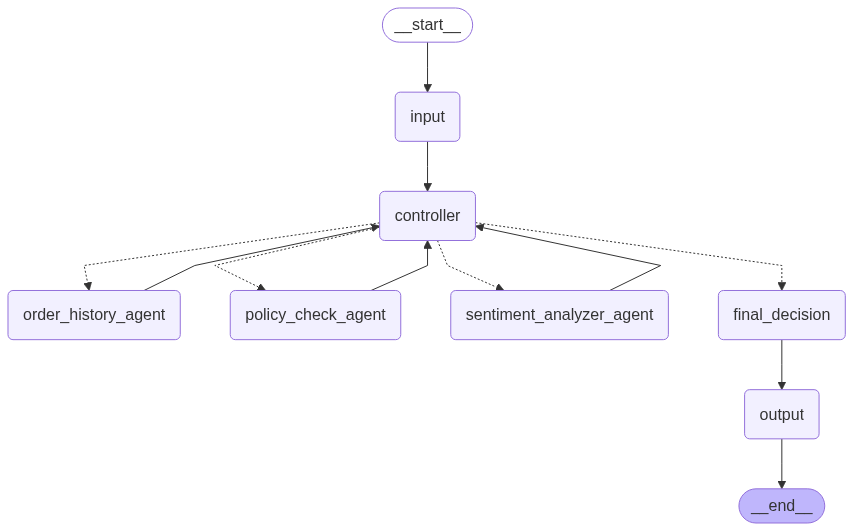

In [12]:
from langgraph.graph import StateGraph
from typing import Dict, List
import random

# State = Our centralized blackboard
class BlackboardState:
    query: str
    product_info: str = ""
    return_policy: str = ""
    customer_sentiment: str = ""
    final_answer: str = ""

# Initialize the blackboard workflow
workflow = StateGraph(BlackboardState)

# --- Define Blackboard Agents (same as before but now write to specific fields) ---
def order_history_agent(state):
    """Writes product availability to blackboard"""
    brands = ["Nike", "Adidas", "Generic"]
    return {"product_info": f"Available ({random.choice(brands)})"}

def policy_check_agent(state):
    """Writes return policy to blackboard"""
    policies = ["30-day return", "Store credit only", "Final sale"]
    return {"return_policy": random.choice(policies)}

def sentiment_analyzer_agent(state):
    """Writes sentiment analysis to blackboard"""
    moods = ["Normal", "Urgent", "Escalate"]
    return {"customer_sentiment": random.choice(moods)}

# --- Controller Logic ---
def controller_agent(state):
    """Decides which agent to activate next based on blackboard state"""
    next_agent = None
    
    # Simple control logic - check what information is missing
    if not state.product_info:
        next_agent = "order_history_agent"
    elif not state.return_policy:
        next_agent = "policy_check_agent"
    elif not state.customer_sentiment:
        next_agent = "sentiment_analyzer_agent"
    else:
        # All information gathered - proceed to final decision
        next_agent = "final_decision"
    
    return {"next_agent": next_agent}

def final_decision_agent(state):
    """Synthesizes the final answer from blackboard contents"""
    decision = (f"Product: {state.product_info}. "
                f"Policy: {state.return_policy}. "
                f"Sentiment: {state.customer_sentiment}")
    return {"final_answer": decision}

# --- Add Nodes ---
workflow.add_node("input", lambda state: {"query": "Can I return this?"})
workflow.add_node("controller", controller_agent)
workflow.add_node("order_history_agent", order_history_agent)
workflow.add_node("policy_check_agent", policy_check_agent)
workflow.add_node("sentiment_analyzer_agent", sentiment_analyzer_agent)
workflow.add_node("final_decision", final_decision_agent)
workflow.add_node("output", lambda state: print(state.final_answer))

# --- Blackboard-Specific Edges ---
workflow.set_entry_point("input")
workflow.add_edge("input", "controller")

# Controller decides the flow dynamically
workflow.add_conditional_edges(
    "controller",
    lambda state: state.next_agent,
    {
        "order_history_agent": "order_history_agent",
        "policy_check_agent": "policy_check_agent",
        "sentiment_analyzer_agent": "sentiment_analyzer_agent",
        "final_decision": "final_decision"
    }
)

# All agents return to controller after completing their task
workflow.add_edge("order_history_agent", "controller")
workflow.add_edge("policy_check_agent", "controller")
workflow.add_edge("sentiment_analyzer_agent", "controller")

# Final steps
workflow.add_edge("final_decision", "output")
workflow.set_finish_point("output")

# --- Visualize ---
app = workflow.compile()
app

## 2. Swarm pattern

The Swarm Pattern is a decentralized, multi-agent approach where several specialized agents work in parallel on the same problem. Each agent contributes a perspective, partial solution, or vote, and a consensus mechanism (such as majority voting, weighted scoring, or confidence aggregation) integrates their outputs into a final decision.

👉 The key aspects are:

Decentralization – no single agent controls the process.

Parallelism – multiple agents work simultaneously.

Consensus – outputs are merged into one reliable result.

Would you like me to also compare the Swarm Pattern with other multi-agent patterns (like Orchestration and Hierarchical), so you can position it better in a presentation?

#### Working 

The system starts with a customer query (e.g., *"Can I return this?"*). Instead of working step-by-step, **three specialized agents activate simultaneously**—each tackling a different aspect:  
- The **order history agent** checks product eligibility (e.g., *"Nike, returnable"*).  
- The **policy agent** reviews store rules (e.g., *"30-day return window"*).  
- The **sentiment agent** gauges customer urgency (e.g., *"Escalate: angry customer"*).  

Each agent submits its answer with a confidence score to a shared pool. A **consensus agent** then tallies the results—like a voting system—and combines the most agreed-upon answers into a final response (e.g., *"Consensus: Return allowed within 30 days (High urgency)."*). Unlike the blackboard’s linear flow, the swarm works in parallel, with agents debating to reach collective agreement.  

### **Example Queries for the Swarm Pattern:**  
1. *"Is my purchase refundable?"*  
   - Agents check product status, policy, and tone simultaneously.  
2. *"I hate this item—give me my money back NOW."*  
   - Sentiment agent flags urgency while policy agent confirms rules.  
3. *"What brands allow exchanges?"*  
   - Order history and policy agents collaborate on brand-specific rules.  
4. *"The website said free returns—is that true?"*  
   - Policy agent verifies, while sentiment detects confusion/frustration.  

**Key Difference:** The swarm thrives on speed (parallel processing) and collective decision-making, while the blackboard is methodical (sequential with a controller). The swarm is ideal when multiple perspectives (e.g., policy + sentiment) need equal weight.

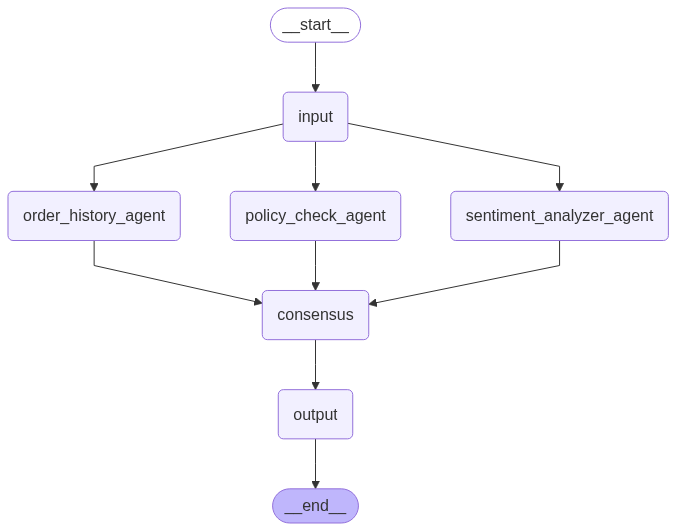

In [11]:
from langgraph.graph import StateGraph
from typing import Dict, List
import random

# State = Our decentralized blackboard
class SwarmState:
    query: str
    partial_answers: List[Dict] = []  # Collective knowledge pool
    consensus_threshold: int = 3      # Min votes for consensus
    final_answer: str = ""

# Initialize the swarm
workflow = StateGraph(SwarmState)

# --- Define Simple Swarm Agents ---
def order_history_agent_agent(state):
    """Basic agent: Checks product availability"""
    brands = ["Nike", "Adidas", "Generic"]
    return {"partial_answers": [{
        "type": "product",
        "answer": f"Available ({random.choice(brands)})",
        "confidence": random.uniform(0.7, 0.9)
    }]}

def policy_check_agent_agent(state):
    """Basic agent: Proposes return policies"""
    policies = ["30-day return", "Store credit only", "Final sale"]
    return {"partial_answers": [{
        "type": "policy", 
        "answer": random.choice(policies),
        "confidence": random.uniform(0.6, 0.8)
    }]}

def sentiment_analyzer_agent_agent(state):
    """Basic agent: Classifies urgency"""
    moods = ["Normal", "Urgent", "Escalate"]
    return {"partial_answers": [{
        "type": "sentiment",
        "answer": random.choice(moods),
        "confidence": random.uniform(0.5, 0.95)
    }]}

# --- Voting/Consensus Mechanism ---
def swarm_consensus_agent(state):
    """Aggregates partial answers through simple voting"""
    if len(state.partial_answers) >= state.consensus_threshold:
        # Simple majority vote (real impl would use confidence-weighted voting)
        product_answers = [a for a in state.partial_answers if a["type"] == "product"]
        final_product = max(set([a["answer"] for a in product_answers]), 
                          key=[a["answer"] for a in product_answers].count)
        
        return {"final_answer": f"Consensus: {final_product}"}
    return {}

# --- Add Nodes ---
workflow.add_node("input", lambda state: {"query": "Can I return this?"})
workflow.add_node("order_history_agent", order_history_agent_agent)
workflow.add_node("policy_check_agent", policy_check_agent_agent) 
workflow.add_node("sentiment_analyzer_agent", sentiment_analyzer_agent_agent)
workflow.add_node("consensus", swarm_consensus_agent)
workflow.add_node("output", lambda state: print(state.final_answer))

# --- Swarm-Specific Edges ---
workflow.set_entry_point("input")

# Parallel agent activation
workflow.add_edge("input", "order_history_agent")
workflow.add_edge("input", "policy_check_agent")
workflow.add_edge("input", "sentiment_analyzer_agent")

# Collective decision-making
workflow.add_edge("order_history_agent", "consensus")
workflow.add_edge("policy_check_agent", "consensus") 
workflow.add_edge("sentiment_analyzer_agent", "consensus")

workflow.add_edge("consensus", "output")
workflow.set_finish_point("output")

# --- Visualize ---
app = workflow.compile()
app

## 3. Supervisor agent

#### Working
The **Supervisor Agent** acts as an intelligent orchestrator that dynamically manages a team of specialized worker agents. Unlike rigid hierarchical or swarm approaches, the supervisor:

1. **Controls Workflow Logic**  
   - Decides which agents to activate (and in what order)  
   - Can skip unnecessary steps (e.g., if policy says "no returns," it won’t check sentiment)  
   - Maintains full context of the process  

2. **Key Responsibilities**  
   - **Task Assignment**: Identifies missing information (e.g., no policy check → activates policy agent)  
   - **Result Synthesis**: Combines worker outputs into a final decision  
   - **Error Handling**: Could retry failed tasks or escalate issues  

3. **Worker Agent Interaction**  
   - Workers (like your original agents) remain single-purpose and unaware of the supervisor  
   - All workers report back to the supervisor, never directly to each other  

4. **Adaptive Execution**  
   ```mermaid
   graph TB
     S(Supervisor) -->|"Need product info?"| A(Order Agent)
     S -->|"Need policy?"| B(Policy Agent)
     S -->|"Need sentiment?"| C(Sentiment Agent)
     A --> S
     B --> S
     C --> S
     S --> O(Output)
   ```

5. **When to Use This Pattern**  
   - When tasks have complex dependencies  
   - If some steps are optional (e.g., skip sentiment check for happy customers)  
   - For workflows requiring real-time adjustments  

**Example Scenario**:  
For the query *"I want to return these shoes"*, the supervisor:  
1. Activates the order agent → Confirms product eligibility  
2. Activates policy agent → Finds "30-day return" policy  
3. **Skips sentiment analysis** (not needed for standard returns)  
4. Automatically approves the return  

This pattern combines the flexibility of swarm agents with the control of hierarchical systems, making it ideal for dynamic, real-world scenarios.

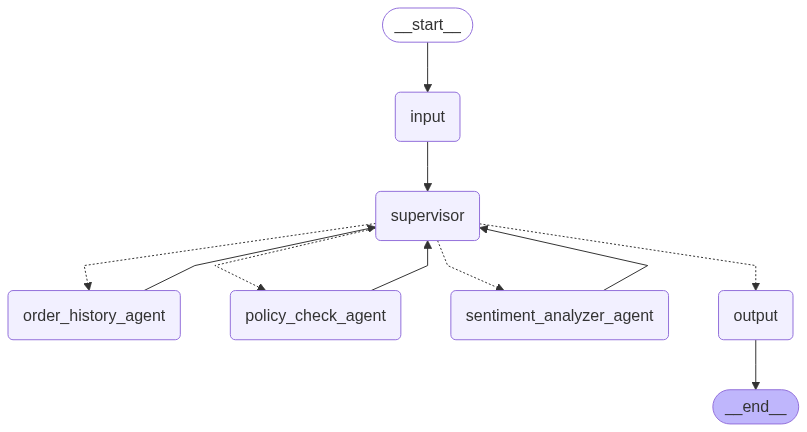

In [15]:
from langgraph.graph import StateGraph
from typing import Dict, List
import random

class SupervisorState:
    query: str
    product_info: str = ""
    return_policy: str = ""
    customer_sentiment: str = ""
    current_task: str = ""
    final_answer: str = ""

workflow = StateGraph(SupervisorState)

# --- Reused Agent Functions ---
# def order_history_agent(state):
# def policy_check_agent(state):
# def sentiment_analyzer_agent(state):

# --- New Supervisor Agent ---
def supervisor_agent(state):
    """Orchestrates the workflow by assigning tasks"""
    # Determine next task based on missing information
    if not state.product_info:
        return {"current_task": "order_history_agent"}
    elif not state.return_policy:
        return {"current_task": "policy_check_agent"}
    elif not state.customer_sentiment:
        return {"current_task": "sentiment_analyzer_agent"}
    else:
        # All data collected - make final decision
        conclusion = (
            f"SUPERVISOR'S DECISION:\n"
            f"• Product Status: {state.product_info}\n"
            f"• Return Policy: {state.return_policy}\n"
            f"• Customer Priority: {state.customer_sentiment}\n"
            f"OUTCOME: {'Approved' if '30-day' in state.return_policy else 'Denied'}"
        )
        return {"final_answer": conclusion, "current_task": None}

# --- Build Workflow ---
workflow.add_node("input", lambda state: {"query": "Can I return this?"})
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("order_history_agent", order_history_agent)
workflow.add_node("policy_check_agent", policy_check_agent)
workflow.add_node("sentiment_analyzer_agent", sentiment_analyzer_agent)
workflow.add_node("output", lambda state: print(state.final_answer))

# --- Supervisor Pattern Edges ---
workflow.set_entry_point("input")
workflow.add_edge("input", "supervisor")

# Dynamic task routing
workflow.add_conditional_edges(
    "supervisor",
    lambda state: state.current_task or "output",  # Default to output if no task
    {
        "order_history_agent": "order_history_agent",
        "policy_check_agent": "policy_check_agent",
        "sentiment_analyzer_agent": "sentiment_analyzer_agent",
        "output": "output"
    }
)

# All workers report back to supervisor
workflow.add_edge("order_history_agent", "supervisor")
workflow.add_edge("policy_check_agent", "supervisor")
workflow.add_edge("sentiment_analyzer_agent", "supervisor")

workflow.set_finish_point("output")

# --- Visualize ---
app = workflow.compile()
app

## 4. Hierarchical 

Here’s a simple definition of the **Hierarchical Multi-Agent Pattern**:  

**The Hierarchical Multi-Agent Pattern** organizes agents into a tree-like structure where higher-level "manager" agents delegate tasks to lower-level "worker" agents, then synthesize their results. Like a corporate hierarchy, decisions flow top-down (from generalists to specialists), while data flows bottom-up (from specialists back to decision-makers).  

### Key Features:  
1. **Layered Authority** – Clear chain of command (e.g., Director → Teams → Specialists).  
2. **Task Delegation** – Managers break problems into subtasks for workers.  
3. **Centralized Synthesis** – Top-level agents combine results into final decisions.  
4. **Reusability** – Workers (like your original agents) stay focused on narrow tasks.  

**Analogies**:  
- Like a company (CEO → Departments → Employees)  
- Like a nervous system (Brain → Spinal Cord → Nerves)  

**When to Use**:  
- For complex problems needing structured coordination  
- When some decisions require broader context than others  
- To mirror real-world organizational structures (e.g., customer service escalation paths)

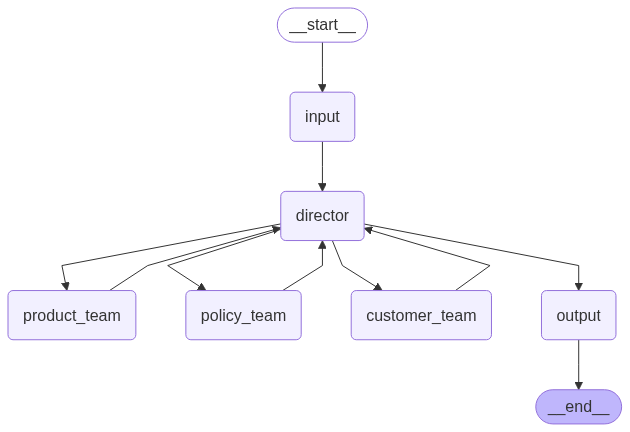

In [13]:
from langgraph.graph import StateGraph
from typing import Dict, List
import random

# State structure
class HierarchicalState:
    query: str
    product_info: str = ""
    return_policy: str = ""
    customer_sentiment: str = ""
    final_answer: str = ""

# Initialize the workflow
workflow = StateGraph(HierarchicalState)

# --- Reused Agent Functions ---
# def order_history_agent(state):
# def policy_check_agent(state):
# def sentiment_analyzer_agent(state):


# --- New Hierarchical Agents ---
def product_team_agent(state):
    """Manager agent for product-related tasks"""
    # Could add product-specific logic here
    return order_history_agent(state)

def policy_team_agent(state):
    """Manager agent for policy-related tasks"""
    # Could add policy-specific logic here
    return policy_check_agent(state)

def customer_team_agent(state):
    """Manager agent for customer-related tasks"""
    # Could add customer-specific logic here
    return sentiment_analyzer_agent(state)

def director_agent(state):
    """Top-level agent that synthesizes all information"""
    if state.product_info and state.return_policy and state.customer_sentiment:
        decision = (f"DIRECTOR'S DECISION:\n"
                   f"- Product: {state.product_info}\n"
                   f"- Policy: {state.return_policy}\n"
                   f"- Priority: {state.customer_sentiment}\n"
                   f"Conclusion: {'Approved' if '30-day' in state.return_policy else 'Denied'}")
        return {"final_answer": decision}
    return {}

# --- Build Hierarchy ---
workflow.add_node("input", lambda state: {"query": "Can I return this?"})
workflow.add_node("product_team", product_team_agent)
workflow.add_node("policy_team", policy_team_agent)
workflow.add_node("customer_team", customer_team_agent)
workflow.add_node("director", director_agent)
workflow.add_node("output", lambda state: print(state.final_answer))

# --- Hierarchical Edges ---
workflow.set_entry_point("input")

# Top-down delegation
workflow.add_edge("input", "director")  # Director gets first look
workflow.add_edge("director", "product_team")  # Delegate to teams
workflow.add_edge("director", "policy_team")
workflow.add_edge("director", "customer_team")

# Bottom-up reporting
workflow.add_edge("product_team", "director")  # Results go back up
workflow.add_edge("policy_team", "director")
workflow.add_edge("customer_team", "director")

workflow.add_edge("director", "output")  # Final decision
workflow.set_finish_point("output")

# --- Visualize ---
app = workflow.compile()
app